# Advanced Road Lane Finding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
import cv2

In [2]:
class Camera(object):
    """
    Camera that we use to take pictures/.
    """
    
    def __init__(self, num_x_corners=9, num_y_corners=6, location='camera_cal'):
        """
        Camera constructor
        """
        
        self.calibrated = False
        self.num_x_corners = num_x_corners
        self.num_y_corners = num_y_corners
        self.location = location
        
        # object points
        self.objp = np.zeros((num_x_corners * num_y_corners, 3), np.float32)
        self.objp[:, :2] = np.mgrid[0:num_x_corners, 0:num_y_corners].T.reshape(-1, 2)
        
        return None
    
    def calibrate(self):
        """
        Calibrates camera given pictures
        """
        
        # 3D points in real-world space
        object_points = []
        # 2D image points
        image_points = []
        
        # load pictures for calibration
        for img in glob.glob(f"{self.location}/*"):
            # find corners
            image = cv2.imread(img)
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            
            ret, corners = cv2.findChessboardCorners(gray, (self.num_x_corners, self.num_y_corners), None)
            
            if ret:
                object_points.append(self.objp)
                image_points.append(corners)
        
        # calibrate camera!
        # gray.shape[::-1] - picture size
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(
                object_points, image_points, gray.shape[::-1],
                None, None
            )
        
        self.calibrated = True
        
        return None
    
    def undistort_picture(self, picture):
        """
        Fixes picture given camera is calibrated
        """
        
        if not self.calibrated:
            raise ValueError("Run camera.calibrate() first!")
        
        undistorted = cv2.undistort(picture, self.mtx, self.dist, None, self.mtx)
        
        return undistorted

In [3]:
camera = Camera()
camera.calibrate()

In [4]:
def plt_images(img_1, title_1, img_2, title_2, cmap='gray'):
    """
    Taken from https://github.com/miguelangel/sdcnd--06_advanced-lane-finding/blob/master/advanced_lane_finding.ipynb
    """
    
    # plot figures
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2, cmap='gray')

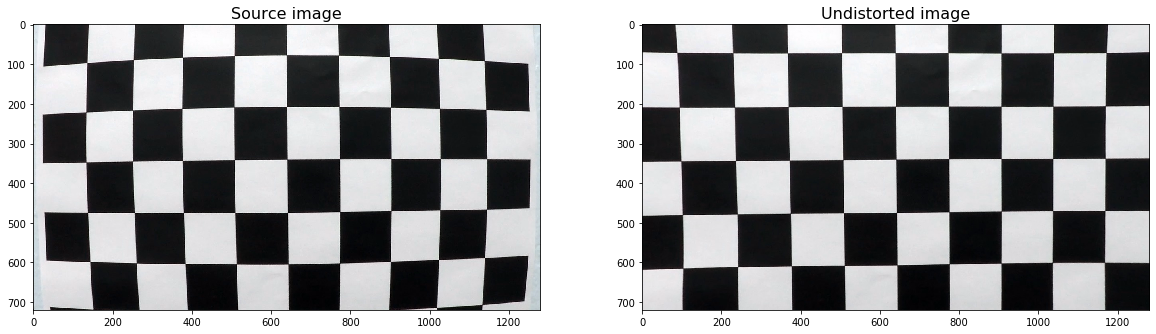

In [249]:
for p in glob.glob('camera_cal/*')[0:1]:
    image = cv2.imread(p)
    plt_images(image, 'Source image', camera.undistort_picture(image), 'Undistorted image')

Apply Sobel operator to extract edges

In [232]:
class CombineTresholds(object):
    
    def __init__(
        self,
        sobel_thresh=(70, 100),
        mag_thresh=(70, 100),
        sobel_kernel=15,
        hls_thresh=(170, 255)
    ):
        """
        Class constructor
        """
        
        self.sobel_thresh = sobel_thresh
        self.mag_thresh = mag_thresh
        self.sobel_kernel = sobel_kernel
        self.hls_thresh = hls_thresh
        
        return None
    
    @staticmethod
    def abs_sobel_thresh(img, orient='x', sobel_thresh=(0, 255)):
        """
        Applies Sobel on a an image.
        Taken from Exercises
        """
    
        # Apply the following steps to img
        # 1) Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 2) Take the derivative in x or y given orient = 'x' or 'y'
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        # 3) Take the absolute value of the derivative or gradient
        # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # 5) Create a mask of 1's where the scaled gradient magnitude 
                # is > thresh_min and < thresh_max
        # 6) Return this mask as your binary_output image
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
        return binary_output
    
    
    @staticmethod
    def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
        """
        Applies thresholds of gradient (X & Y directions)
        Taken from Exercises
        """
    
        # Apply the following steps to img
        # 1) Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 3) Calculate the magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8)
        # 5) Create a binary mask where mag thresholds are met
        binary_output = np.zeros_like(gradmag)
        # 6) Return this mask as your binary_output image
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
        return binary_output
    
    @staticmethod
    def dir_threshold(img, sobel_kernel=15, thresh=(0.5, np.pi/2)):
        """
        Apply threshold to abs gradient.
        Taken from Exercises
        """
    
        # Apply the following steps to img
        # 1) Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 3) Take the absolute value of the x and y gradients
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
        # 5) Create a binary mask where direction thresholds are met
        # 6) Return this mask as your binary_output image
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

        return binary_output
    
    @staticmethod
    def hls_select(img, hls_thresh=(0, 255)):
        """
        Color selection.
        Taken from Exercise
        """
        
        # 1) Convert to HLS color space
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        
        # 2) Apply a threshold to the S channel
        s_channel = hls[:, :, 2]
        binary_output = np.zeros_like(s_channel)
        
        # 3) Return a binary image of threshold result
        binary_output[(s_channel > hls_thresh[0]) & (s_channel <= hls_thresh[1])] = 1
        
        return binary_output
    
    def apply_thresholds(self, image):
        """
        Apply all thresholds.
        Taken from Exercise
        """
        
        grad_x = CombineTresholds.abs_sobel_thresh(
            image,
            orient='x',
            sobel_thresh=self.sobel_thresh
        )
        
        grad_y = CombineTresholds.abs_sobel_thresh(
            image,
            orient='y',
            sobel_thresh=self.sobel_thresh
        )
        
        mag_binary = CombineTresholds.mag_thresh(
            image,
            sobel_kernel=self.sobel_kernel,
            mag_thresh=self.mag_thresh
        )
        
        dir_binary = CombineTresholds.dir_threshold(
            image,
            sobel_kernel=self.sobel_kernel
        )
        
        hls_binary = CombineTresholds.hls_select(
            image,
            hls_thresh=self.hls_thresh
        )
        
        # combine
        combined = np.zeros_like(dir_binary)
        combined[((grad_x == 1) & (grad_y == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
        
        return combined

In [233]:
combine_thresholds = CombineTresholds()

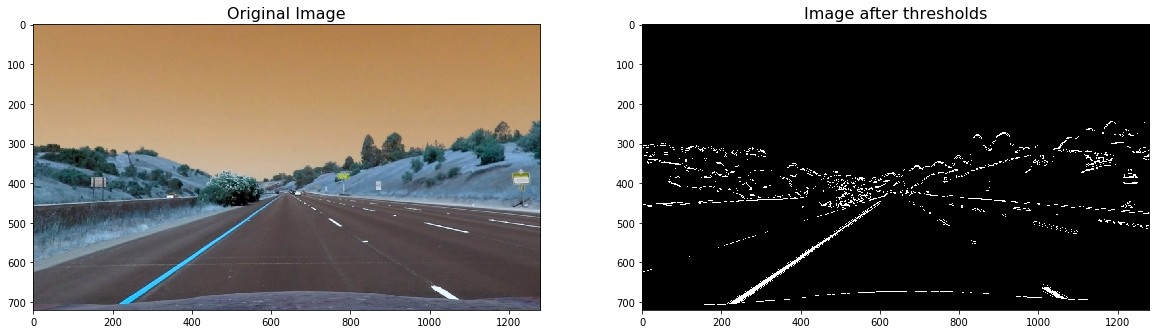

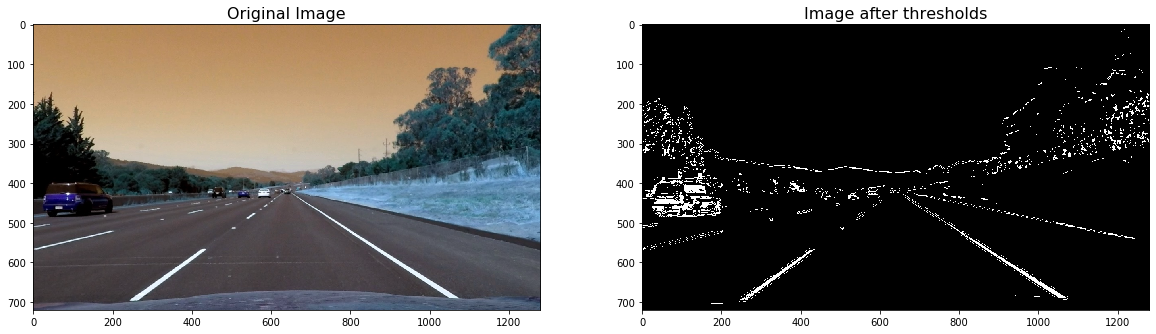

In [234]:
for i in range(len(glob.glob('test_images/*')[0:2])):
    image = camera.undistort_picture(cv2.imread(glob.glob('test_images/*')[i]))
    applied_thresholds = combine_thresholds.apply_thresholds(image)

    # Plot the result
    plt_images(image, 'Original Image', applied_thresholds, 'Image after thresholds')

**Perspective Transform**

In [235]:
class PerspectiveTransform(object):
    
    def __init__(self, custom_src=None, custom_dst=None):
        """
        Constructs Perspective Transformer
        Inputs:
        =======
        custom_src (np.array): custom coordinates in source image
        custom_dst (np.array): custom coordinates in destination image
        """
        
        self.custom_src = custom_src
        self.custom_dst = custom_dst
        
        return None
    
    def transform_perspective(self, image):
        """
        Given image, transform perspective
        """
        
        offset = 100
        
        # get image shape
        height = image.shape[0]
        width = image.shape[1]
        
        # get source image coordinate
        source_image_corner_1 = [width // 2 - 80, height*0.625]
        source_image_corner_2 = [width // 2 + 80, height*0.625]
        source_image_corner_3 = [-offset, height]
        source_image_corner_4 = [width+offset, height]
        src = np.float32(
            [
                source_image_corner_1,
                source_image_corner_2,
                source_image_corner_3,
                source_image_corner_4
            ]
        )
        
        destination_image_corner_1 = [offset, 0]
        destination_image_corner_2 = [width-offset, 0]
        destination_image_corner_3 = [offset, height]
        destination_image_corner_4 = [width-offset, height]
        
        dst = np.float32(
            [
                destination_image_corner_1,
                destination_image_corner_2,
                destination_image_corner_3,
                destination_image_corner_4
            ]
        )
        
        # this is needed for drawing lanes on the videos that have different size
        if self.custom_src is not None and self.custom_dst is not None:
            src = self.custom_src
            dst = self.custom_dst
        
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(image, M, (width, height))
        # compute M inverse for plotting later
        Minverse = cv2.getPerspectiveTransform(dst, src)
        
        return warped, M, Minverse

In [236]:
perspective_transform = PerspectiveTransform()

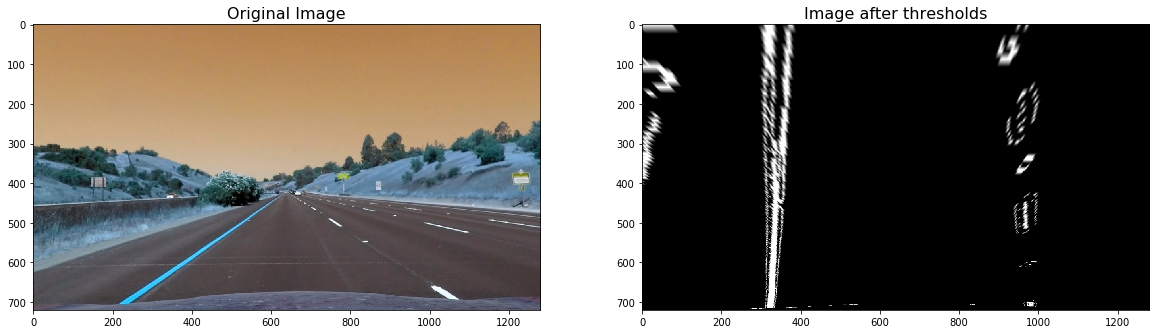

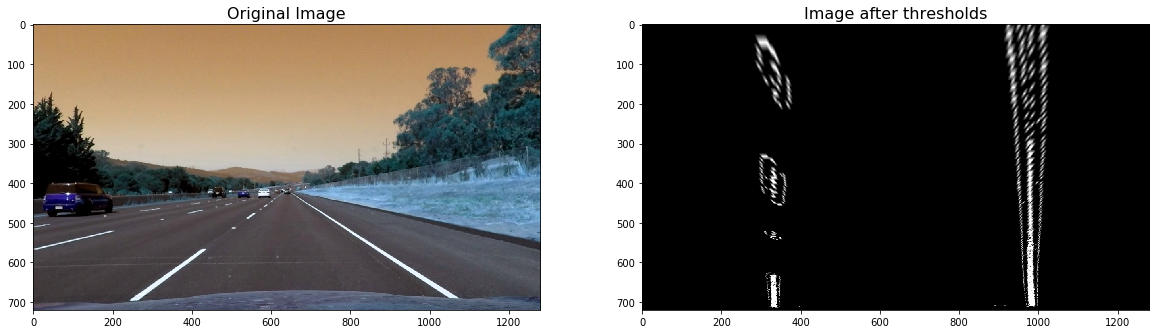

In [237]:
for i in range(len(glob.glob('test_images/*')[0:2])):
    image = camera.undistort_picture(cv2.imread(glob.glob('test_images/*')[i]))
    applied_thresholds = combine_thresholds.apply_thresholds(image)
    
    # change perspective
    new_perspective_image, _, Minverse = perspective_transform.transform_perspective(applied_thresholds)

    # Plot the result
    plt_images(image, 'Original Image', new_perspective_image, 'Image after thresholds')

In [188]:
class FindLanes(object):
    """
    Finds Lanes on warped images.
    Taken from Exercises
    """
    
    def __init__(self, nwindows=15, margin=200, minpix=20):
        """
        Asssign some parameters
        """
        
        self.nwindows = nwindows
        self.margin = margin
        self.minpix = minpix
        
        return None

    def find_lanes(self, binary_warped):
        """
        Given picture, finds lanes using histogram approach
        """
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0] // 2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = self.nwindows
        # Set the width of the windows +/- margin
        margin = self.margin
        # Set minimum number of pixels found to recenter window
        minpix = self.minpix

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 

            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # fit polynomial
        # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)        
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
        # Draw left and right lines
        for index in range(binary_warped.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
        
        return left_fit, right_fit, left_fitx, right_fitx, ploty, out_img
    
    def find_lanes_recursive(self, binary_warped, previous_fits):
        """
        Find lanes using fitted lines from previous image
        """
        
        if not previous_fits:
            return self.find_lanes(binary_warped)
        
        left_fit = previous_fits[0]
        right_fit = previous_fits[1]
        
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        if (leftx.size == 0 or rightx.size == 0):
            return self.find_lanes(binary_warped)
        
        # fit second order polynomial 
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
     
        for index in range(binary_warped.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255, 255, 0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255, 255, 0))

        return left_fit, right_fit, left_fitx, right_fitx, ploty, out_img
    
    @staticmethod
    def measure_lane_curvature(img_shape, leftx, rightx):
        """
        Measure curvature of the detected lane
        """
        # compute y axis
        ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty)
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculation of R_curve (radius of curvature)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        return left_curverad, right_curverad
    
    
    @staticmethod
    def draw_lanes_on_image(img, warped_img, left_fitx, right_fitx, ploty, Minv):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(img).astype(np.uint8)

        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(warp_zero, np.int_([pts]), (0, 255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(warp_zero, Minv, (img.shape[1], img.shape[0])) 

        # Combine the result with the original image
        return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

In [189]:
lane_finder = FindLanes(
    nwindows=15,
    margin=70,
    minpix=30
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


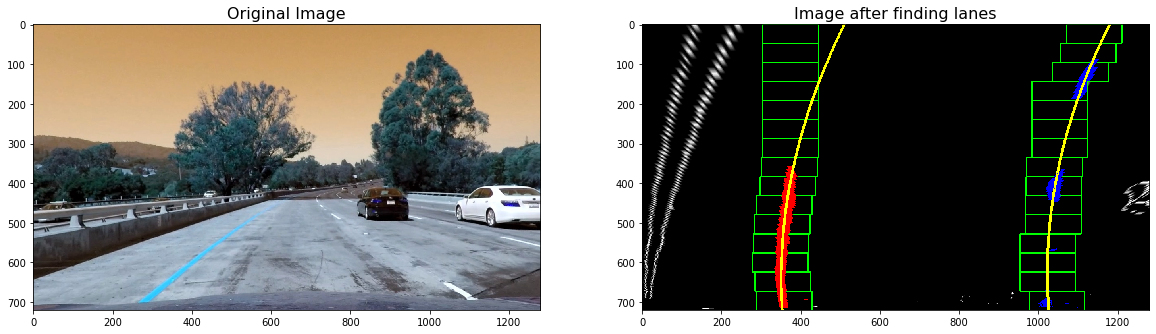

In [190]:
left_fit, right_fit, left_fitx, right_fitx, ploty, out_img = lane_finder.find_lanes(new_perspective_image)
plt_images(image, 'Original Image', out_img, 'Image after finding lanes')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


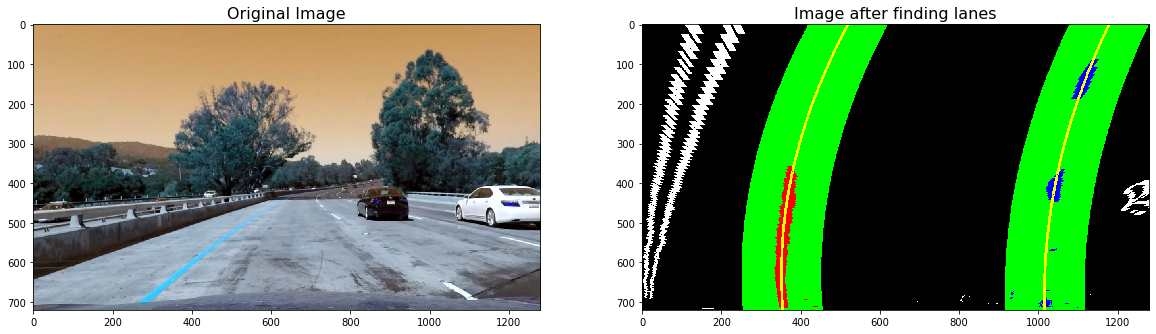

In [191]:
left_fit, right_fit, left_fitx, right_fitx, ploty, out_img = lane_finder.find_lanes_recursive(new_perspective_image, (left_fit, right_fit))
plt_images(image, 'Original Image', out_img, 'Image after finding lanes')

In [192]:
lane_finder.measure_lane_curvature(new_perspective_image.shape, left_fitx, right_fitx)

(386.09503265179285, 469.47919360315245)

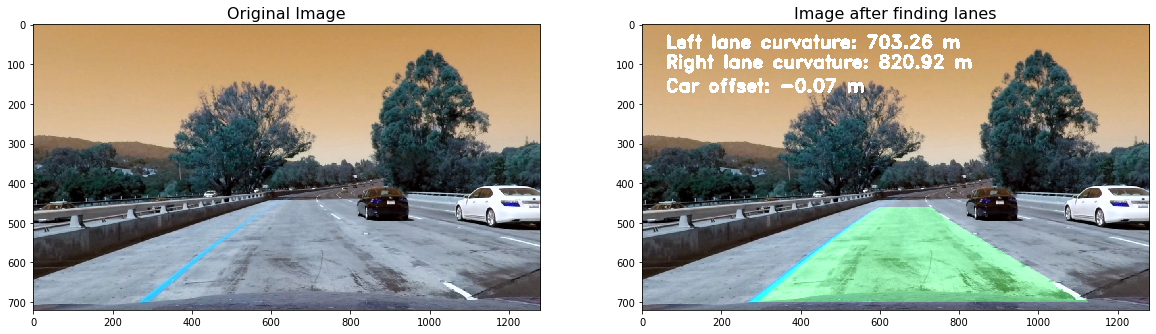

In [262]:
image = camera.undistort_picture(cv2.imread(glob.glob('test_images/*')[i-7]))
applied_thresholds = combine_thresholds.apply_thresholds(image)

# change perspective
new_perspective_image, M, Minverse = perspective_transform.transform_perspective(applied_thresholds)

# find lanes
left_fit, right_fit, left_fitx, right_fitx, ploty, out_img = lane_finder.find_lanes(new_perspective_image)

lanes = lane_finder.draw_lanes_on_image(image, new_perspective_image, left_fitx, right_fitx, ploty, Minverse)

lanes_fin = add_metrics(lanes, left_fitx, right_fitx)

plt_images(image, 'Original Image', lanes_fin, 'Image after finding lanes')

In [252]:
def distance_from_camera(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    # Find middle of the picture (horizontally)
    mid_imgx = img_shape[1]//2
        
    # Car position with respect to the lane (average)
    car_pos = (leftx[-1] + rightx[-1])/2
    
    # Car position
    offsetx = (mid_imgx - car_pos) * xm_per_pix

    return offsetx

In [261]:
def add_metrics(img, leftx, rightx):    
    # Calculate radius of curvature
    curvature_rads = lane_finder.measure_lane_curvature(leftx=leftx, rightx=rightx, img_shape=img.shape)

    # Calculate distance from camera
    offset = distance_from_camera(leftx, rightx, img.shape)
    
    # Display lane curvature
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane curvature: {:.2f} m'.format(curvature_rads[0]), 
                (60, 60), 2, 1.5, (255, 255, 255), 5)
    cv2.putText(out_img, 'Right lane curvature: {:.2f} m'.format(curvature_rads[1]), 
                (60, 110), 2, 1.5, (255, 255, 255), 5)
    cv2.putText(out_img, 'Car offset: {:.2f} m'.format(offset), 
                (60, 170), 2, 1.5, (255, 255, 255), 5)
    
    return out_img

**Lane Finding Pipeline**

In [254]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [255]:
# make instances of every transformer in the pipeline

camera = Camera()
camera.calibrate()

combine_thresholds = CombineTresholds()
perspective_transform = PerspectiveTransform(
    custom_src=np.float32(
            [[280,  700],
             [595,  460],
             [725,  460],
             [1125, 700]
            ]
    ),
    custom_dst=np.float32(
            [[250,  720],
             [250,    0],
             [1065,   0],
             [1065, 720]]
    )
)

lane_finder = FindLanes(
    nwindows=15,
    margin=70,
    minpix=30
)

In [256]:
def process_image(image):
    """
    Pipeline to find lanes on the given image
    """

    undistorted_image = camera.undistort_picture(image)
    
    applied_thresholds = combine_thresholds.apply_thresholds(undistorted_image)

    # change perspective
    new_perspective_image, M, Minverse = perspective_transform.transform_perspective(applied_thresholds)

    # find lanes
    left_fit, right_fit, left_fitx, right_fitx, ploty, out_img = lane_finder.find_lanes(new_perspective_image)

    # draw lanes
    lanes = lane_finder.draw_lanes_on_image(image, new_perspective_image, left_fitx, right_fitx, ploty, Minverse)

    # add metrics on the screen
    lanes_fin = add_metrics(lanes, left_fitx, right_fitx)

    return lanes_fin

In [263]:
input_video = 'project_video.mp4'
output_video = 'project_video_wih_lanes.mp4'

In [264]:
clip1 = VideoFileClip(input_video)
image_with_lanes
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(output_video, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_wih_lanes.mp4.
Moviepy - Writing video project_video_wih_lanes.mp4



Moviepy - Done !
Moviepy - video ready project_video_wih_lanes.mp4
CPU times: user 6min 3s, sys: 54.4 s, total: 6min 58s
Wall time: 5min 29s


In [265]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))